In [37]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import json
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import tree
from sklearn.model_selection import train_test_split

In [38]:
from config import remote_db_endpoint, remote_db_port, remote_db_user, remote_db_pwd, remote_db_name

In [39]:
cloud_engine = create_engine(f"postgresql://{remote_db_user}:{remote_db_pwd}@{remote_db_endpoint}:{remote_db_port}/{remote_db_name}")

In [40]:
cloud_conn = cloud_engine.connect()

In [41]:
africa_data = pd.read_sql("select * from ultimate", cloud_conn)

africa_data.columns

Index(['country_name', 'country_code', 'year', 'conflict_code_freq',
       'conflict_deaths_code', 'population_density',
       'population_growth_annual_per', 'total_population',
       'refugee_pop_origin', 'rural_population', 'rural_population_per',
       'rural_population_growth', 'urban_population', 'urban_population_per',
       'urban_population_growth', 'corruption_control_estimate',
       'corruption_control_percentile', 'government _effectiveness_est',
       'government_effectiveness_percentile', 'stability_est',
       'stability_percentile', 'regulatory_est', 'regulatory_percentile',
       'ruleoflaw_est', 'ruleoflaw_percentile', 'accountability_est',
       'accountability_percentile ', 'ethnic_score', 'gdp_growth_per',
       'gdp_percap_per', 'mortality_rate', 'gdp_total', 'gdp_percap',
       'gni_total', 'fdi_inflows_gdp', 'fdi_inflows_total',
       'conflict_fatalities', 'conflict_events'],
      dtype='object')

In [42]:
africa_data=africa_data[['gdp_percap', 'accountability_est', 'government _effectiveness_est', 'ethnic_score', 'gni_total','stability_est', 'mortality_rate', 'ruleoflaw_est', 'corruption_control_estimate', 'conflict_code_freq']]

africa_data.head()


,gdp_percap,accountability_est,government _effectiveness_est,ethnic_score,gni_total,stability_est,mortality_rate,ruleoflaw_est,corruption_control_estimate,conflict_code_freq
0,771.60,-1.54,-1.55,0.411,8.400638e+09,-1.17,56.1,-1.85,-1.36,4
1,476.56,-1.67,-1.33,0.407,5.480617e+09,-1.27,57.7,-1.82,-1.31,4
2,306.71,-1.31,-1.55,0.909,7.495003e+08,-2.35,118.0,-2.17,-1.08,1
3,300.43,-1.17,-1.66,0.908,7.726000e+08,-2.15,126.0,-2.09,-1.29,1
4,138.59,-1.73,-1.88,0.726,5.824731e+09,-2.47,111.0,-2.13,-1.72,5


In [43]:
target_names=['No Risk', 'Minimal Risk', 'Moderate Risk', 'Increased Risk', 'High Risk', 'Extreme Risk']

In [44]:
feature_names=['gdp_percap', 'accountability_est', 'government _effectiveness_est', 'ethnic_score', 'gni_total','stability_est', 'ruleoflaw_est', 'mortality_rate', 'corruption_control_estimate']
len(feature_names)

9

In [45]:
target_df=africa_data['conflict_code_freq']
y=target_df.to_numpy()
y

array([4, 4, 1, ..., 1, 1, 1], dtype=int64)

In [46]:
data_df=africa_data
data_df=data_df.drop('conflict_code_freq', 1)
X=data_df.to_numpy()
len(X[0])

9

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [48]:

# step 1
rf = RandomForestClassifier(n_estimators=100)

# step 2
rf.fit(X_train, y_train)

# step 3 
y_pred=rf.predict(X_test)


In [49]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9817073170731707


In [50]:
importances = rf.feature_importances_
importances

array([0.0964659 , 0.10086012, 0.11440832, 0.2463285 , 0.12899496,
       0.07912876, 0.07939066, 0.08208735, 0.07233544])

In [51]:
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=2,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=2, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [52]:
feature_imp = pd.Series(rf.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

ethnic_score                     0.246329
gni_total                        0.128995
government _effectiveness_est    0.114408
accountability_est               0.100860
gdp_percap                       0.096466
mortality_rate                   0.082087
ruleoflaw_est                    0.079391
stability_est                    0.079129
corruption_control_estimate      0.072335
dtype: float64

In [53]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
clf.score(X, y)

1.0

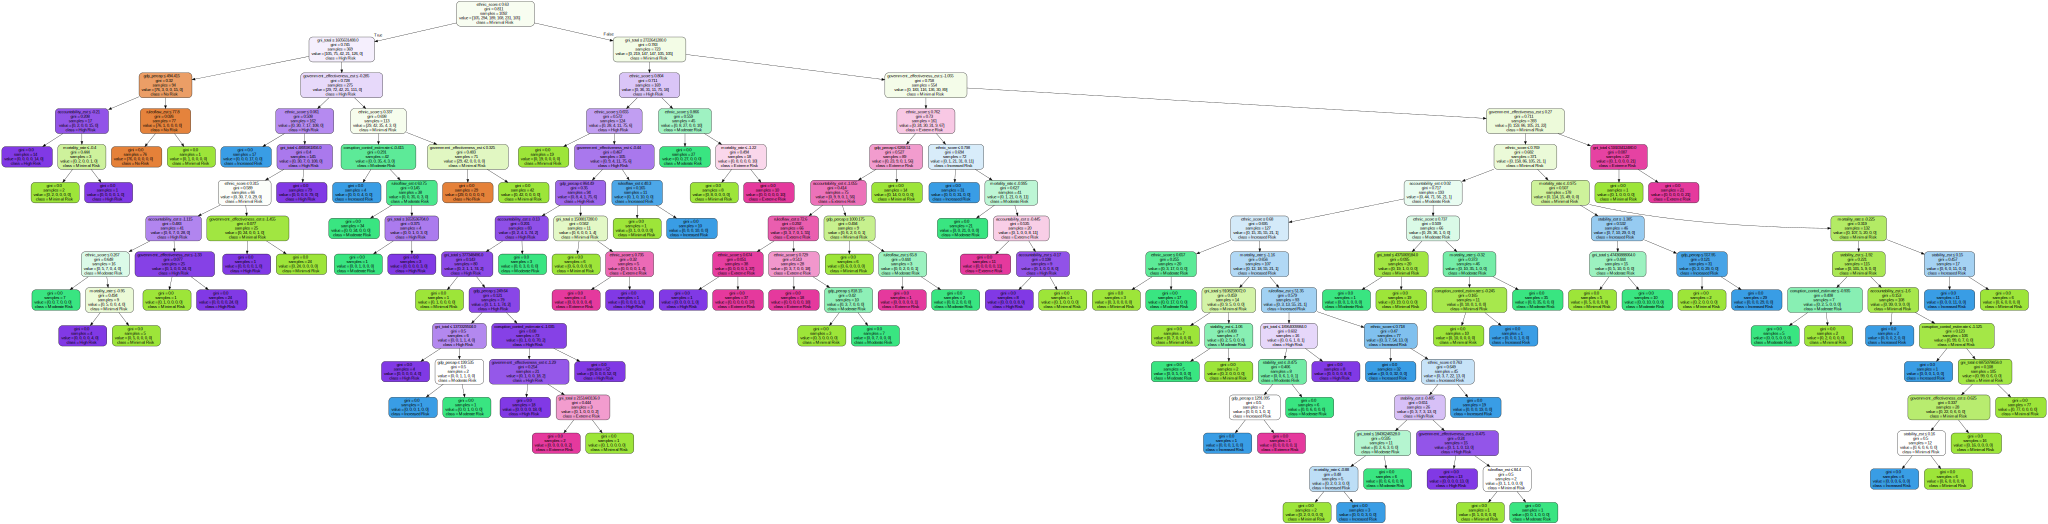

In [54]:
import graphviz 
dot_data = tree.export_graphviz(
    clf, out_file=None, 
    feature_names=feature_names,  
    class_names=target_names,  
    filled=True, rounded=True,  
    special_characters=True)  

import pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('finalrf.png')

graph = graphviz.Source(dot_data)  
graph 